### A simple take on Kaggle's Airbus Ship Detection Challenge

For more detailed explanations, please refer to Julián Peller excellent kernel series at:
https://www.kaggle.com/julian3833/3-basic-exploratory-analysis

In [1]:
# Import libraries
import os, PIL

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set visualization style
plt.rcParams["patch.force_edgecolor"] = True
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

List Files in Directory

In [3]:
ls

EDA.ipynb                     test/
LICENSE                       test_ship_segmentations.csv*
Modeling.ipynb                train/
README.md                     train_box_pixels.csv
Strategies                    train_ship_segmentations.csv*
sample_submission.csv*


In [4]:
# Read Data
df = pd.read_csv('train_ship_segmentations.csv')
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [5]:
# Features Engineering - We will use EncodedPixels in a second DataFrame bellow
df['Ships'] = df['EncodedPixels'].notnull()
df = df.groupby('ImageId').sum().reset_index()
df['ShipPresent'] = df['Ships'] > 0

df.head()

,ImageId,Ships,ShipPresent
0,00003e153.jpg,0.0,False
1,000155de5.jpg,1.0,True
2,00021ddc3.jpg,9.0,True
3,0002756f7.jpg,2.0,True
4,0002d0f32.jpg,0.0,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104070 entries, 0 to 104069
Data columns (total 3 columns):
ImageId        104070 non-null object
Ships          104070 non-null float64
ShipPresent    104070 non-null bool
dtypes: bool(1), float64(1), object(1)
memory usage: 1.7+ MB


In [7]:
# Features Engineering - Second DataFrame with EncodedPixels and only images with ships

df_box = pd.read_csv('train_ship_segmentations.csv')
df_box = df_box.dropna().groupby("ImageId")[['EncodedPixels']].agg(lambda rle_code: ' '.join(rle_code)).reset_index()
df_box['Path'] = df_box['ImageId'].apply(lambda filename: os.path.join('train/', filename))
df_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29070 entries, 0 to 29069
Data columns (total 3 columns):
ImageId          29070 non-null object
EncodedPixels    29070 non-null object
Path             29070 non-null object
dtypes: object(3)
memory usage: 681.4+ KB


In [8]:
df_box.head()

,ImageId,EncodedPixels,Path
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,train/000155de5.jpg
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,train/00021ddc3.jpg
2,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,train/0002756f7.jpg
3,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,train/00031f145.jpg
4,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...,train/00053c6ba.jpg


In [9]:
def rle_to_pixels(rle_code):
    ''' This function decodes Run Lenght Encoding into pixels '''
    rle_code = [int(i) for i in rle_code.split()]
    
    pixels = [(pixel_position % 768, pixel_position // 768) 
              for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
              for pixel_position in range(start, start + length)]
        
    return pixels

def apply_mask(image, mask):
    ''' This function saturates the Red and Green RGB colors in the image 
        where the coordinates match the mask'''
    for x, y in mask:
        image[x, y, [0, 1, 2]] = (255, 255, 0)
    return image

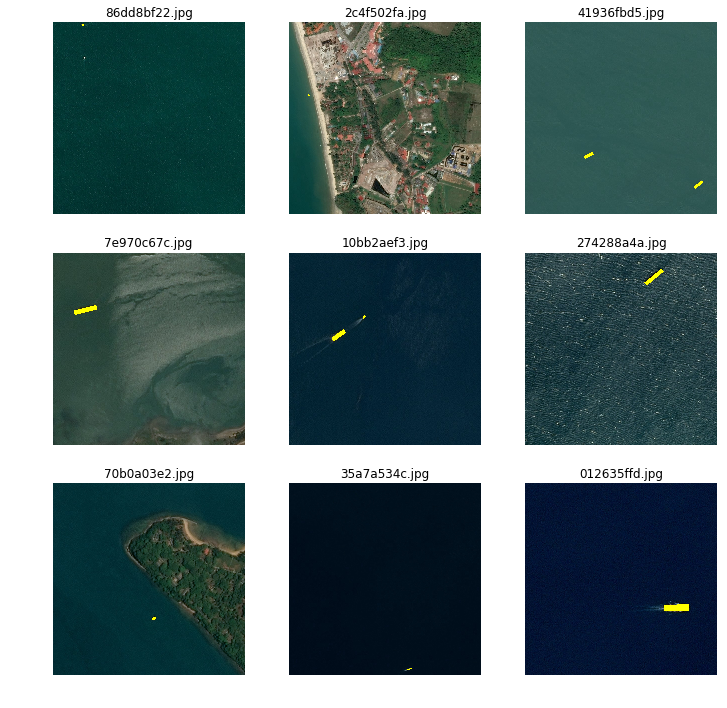

In [10]:
# Plots with masked ships on random images from the dataset

h, w = 3, 3
load_img = lambda path: np.array(PIL.Image.open(path))
fig, axes_list = plt.subplots(h, w, figsize=(4*h, 4*w))

for axes in axes_list:
    for ax in axes:
        ax.axis("off")
        path = np.random.choice(df_box['Path'])
        img = apply_mask(load_img(path), \
                rle_to_pixels(df_box[df_box['Path'] == path]['EncodedPixels'].iloc[0]))
        ax.imshow(img)
        ax.set_title(df_box[df_box['Path'] == path]['ImageId'].iloc[0])

In [11]:
df_box.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29070 entries, 0 to 29069
Data columns (total 3 columns):
ImageId          29070 non-null object
EncodedPixels    29070 non-null object
Path             29070 non-null object
dtypes: object(3)
memory usage: 681.4+ KB


In [12]:
# Imbalanced Dataset | Ship/No-Ship Ratio

total_images = len(df)
ships = df['Ships'].sum()
ships_images = len(df[df['Ships'] > 0])
no_ship = total_images - ships_images

print(f"Images: {total_images} \nShips:  {ships}")
print(f"Images with ships:    {round(ships_images/total_images,2)} ({ships_images})")
print(f"Images with no ships: {round(no_ship/total_images,2)} ({no_ship})")

Images: 104070 
Ships:  56030.0
Images with ships:    0.28 (29070)
Images with no ships: 0.72 (75000)


In [13]:
# Engineering Features for the graphs

ship_ratio = df['ShipPresent'].value_counts()/total_images
ship_ratio = ship_ratio.rename(index={True:'Ship', False:'No Ship'})

total_ship_distribution = df['Ships'].value_counts()[1::]/ships_images

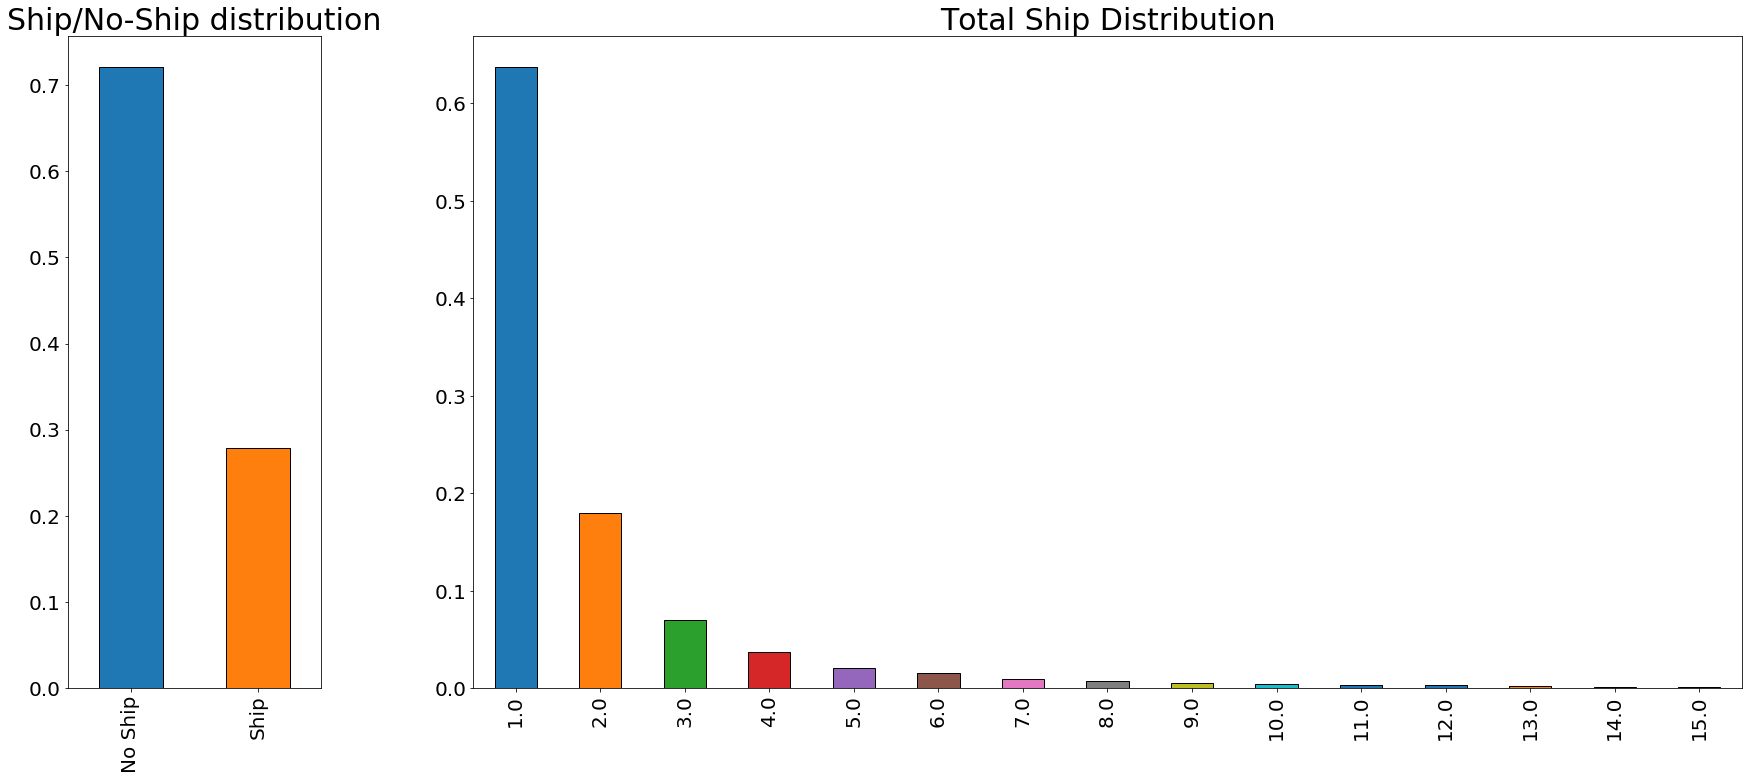

In [14]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 12), gridspec_kw={'width_ratios':[1,5]})

ship_ratio.plot.bar(ax=axes[0], title="Ship/No-Ship distribution")
total_ship_distribution.plot.bar(ax=axes[1], title="Total Ship Distribution")

axes[0].title.set_size(30)
axes[1].title.set_size(30)

In [15]:
# The operation bellow is expensive, if possible just load the pre-calculated dataset

# df_box['Pixels'] = df_box['EncodedPixels'].apply(rle_to_pixels).str.len() # EXPENSIVE
# df_box.to_csv('train_box_pixels.csv', encoding='utf-8', index=False)
df_box = pd.read_csv('train_box_pixels.csv')
df_box.head()

,ImageId,EncodedPixels,Path,Pixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,train/000155de5.jpg,3388
1,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,train/00021ddc3.jpg,1176
2,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,train/0002756f7.jpg,408
3,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,train/00031f145.jpg,425
4,00053c6ba.jpg,565382 3 566144 9 566909 12 567677 13 568445 1...,train/00053c6ba.jpg,174


In [16]:
# Imbalanced Dataset | Ship/No-Ship Pixels Ratio
# Due to the heavy imbalance of the dataset, we'll conduct our analysis only with ship images

n_images = df_box['ImageId'].nunique()
ship_pixels = df_box['Pixels'].sum()
total_pixels = n_images * 768 * 768
ratio = ship_pixels/total_pixels

print(f'Ship Pixels:   {round(ratio, 3)*100}%    ({ship_pixels})')
print(f'Total Pixels: {round(1 - ratio, 3)*100}% ({total_pixels - ship_pixels})')

Ship Pixels:   0.5%    (87714996)
Total Pixels: 99.5% (17058468684)
